# Synthetic Colon Cancer – Advanced Machine Learning Analysis

This notebook demonstrates a professional end-to-end ML workflow on the `Synthetic_ColonCancer.csv` dataset.

It is a fully reusable ML pipeline designed to showcase my understanding of EDA, preprocessing, PCA, classical machine-learning models, and a neural network while allowing any tabular classification dataset, including high-dimensional gene expression data, to be swapped in simply by changing the file path and target column. It demonstrates how I begin with a baseline model and then improve robustness and performance through more advanced approaches, reflecting both engineering structure and biological insight. By translating complex biomedical problems into clean, scalable, and reproducible engineering solutions, this project highlights my ability to generate meaningful analytical outputs that directly support data-driven decision-making and align with modern company goals.



## 1. Configuration & Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Load Data
Change `FILE_PATH` and `TARGET_COL` if you want to reuse this notebook for a different dataset.

In [2]:

#File path can be changed so other classification dataset can be used
FILE_PATH = "Synthetic_ColonCancer.csv"
TARGET_COL = "Class" #name of the target column

df = pd.read_csv(FILE_PATH)
print("Shape:", df.shape)
df.head()


Shape: (62, 2001)


,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Gene_1992,Gene_1993,Gene_1994,Gene_1995,Gene_1996,Gene_1997,Gene_1998,Gene_1999,Gene_2000,Class
0,7.993428,6.723471,8.295377,10.046060,6.531693,6.531726,10.158426,8.534869,6.061051,8.085120,...,8.508583,9.377827,8.416608,7.702896,9.140300,6.946957,5.236251,6.673866,5.510195,1
1,5.649643,6.710963,5.415160,6.384077,3.212771,7.426587,7.002411,5.365823,8.318491,8.875140,...,6.057473,3.049024,8.502199,2.869834,7.056915,2.844376,6.359404,10.286756,7.721296,1
2,5.273013,6.937593,7.036034,7.945261,4.266283,8.185135,1.591217,5.740231,6.023452,8.266654,...,7.612779,5.003386,8.037586,8.727056,7.342939,9.305296,4.565192,7.935901,4.659439,1
3,4.771837,5.738138,5.115880,5.904008,6.571699,8.674309,6.357682,3.828749,9.280136,5.325820,...,6.951427,10.277921,8.816045,5.585121,11.419711,7.653989,5.329751,10.305826,11.155555,1
4,6.933949,5.992699,6.655250,8.429463,9.555713,8.140975,7.203446,9.996024,6.374327,9.061839,...,7.382901,8.324338,4.002729,9.388429,9.602204,3.003310,5.589367,7.991531,8.288777,1


## 3. Basic Exploratory Data Analysis (EDA)
I inspect structure, missing values, and class balance.

In [3]:
print("Data types (first 10 columns):\n", df.dtypes.head(10))
print("\nMissing values per column (top 10):\n")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nTarget distribution (counts):")
print(df[TARGET_COL].value_counts())
print("\nTarget distribution (percent):")
print(df[TARGET_COL].value_counts(normalize=True) * 100)

# Basic statistics
df.describe().T.head(10)


Data types (first 10 columns):
 Gene_1     float64
Gene_2     float64
Gene_3     float64
Gene_4     float64
Gene_5     float64
Gene_6     float64
Gene_7     float64
Gene_8     float64
Gene_9     float64
Gene_10    float64
dtype: object

Missing values per column (top 10):

Class        0
Gene_1985    0
Gene_1984    0
Gene_1983    0
Gene_1982    0
Gene_1981    0
Gene_1980    0
Gene_1979    0
Gene_1978    0
Gene_1977    0
dtype: int64

Target distribution (counts):
Class
0    40
1    22
Name: count, dtype: int64

Target distribution (percent):
Class
0    64.516129
1    35.483871
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Gene_1,62.0,5.693822,2.072230,0.403280,4.428144,5.653448,6.870670,11.340510
Gene_2,62.0,5.850566,1.768379,2.689290,4.409613,5.746239,6.745471,9.598380
Gene_3,62.0,5.709967,2.155162,0.558678,4.503058,5.725371,6.783054,11.470855
Gene_4,62.0,5.631559,2.304927,0.232094,4.007892,6.033607,7.298501,10.728827
Gene_5,62.0,5.569228,2.374678,-0.463079,3.919913,5.471175,6.984652,11.961302
Gene_6,62.0,5.286184,2.190192,0.301609,3.791671,5.453798,6.794486,10.636929
Gene_7,62.0,5.686934,2.079386,0.183347,4.623682,5.810181,6.815196,10.158426
Gene_8,62.0,5.668009,2.122084,1.647789,4.201116,5.466510,6.865905,11.024060
Gene_9,62.0,5.854075,1.890224,2.135392,4.345187,5.964840,7.114952,9.509858
Gene_10,62.0,6.017645,2.537279,-0.446129,4.535775,6.254331,7.976994,11.333768


### 3.1 Histograms for a few example features
For high-dimensional data (like 2000 genes), plotting every feature is not helpful. Instead, I show histograms for a small subset of features to illustrate distribution shapes.

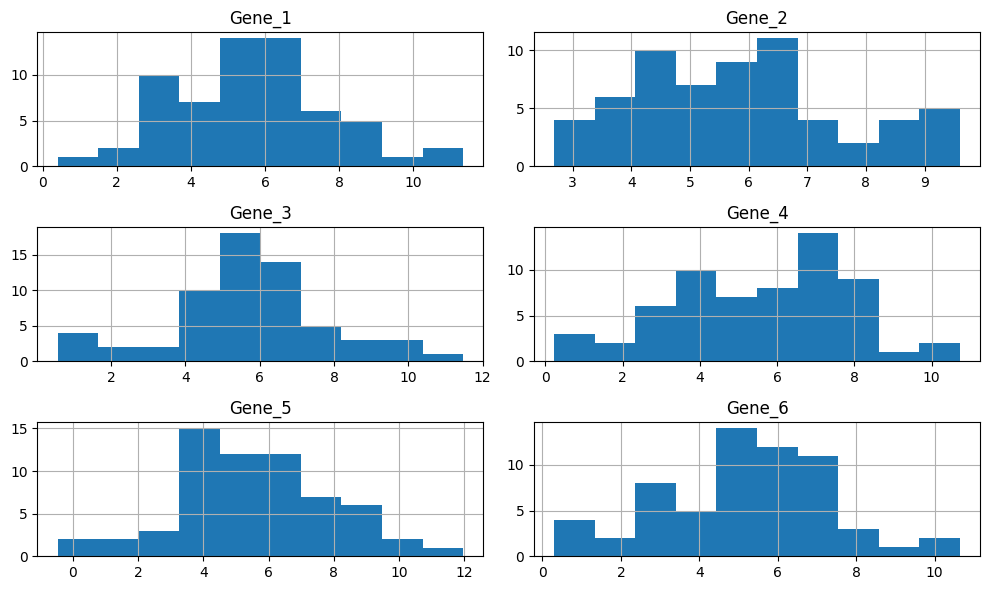

In [4]:

# Histograms plots for a small subset of features (e.g., first 6 genes)
example_features = df.drop(columns=[TARGET_COL]).columns[:6]

df[example_features].hist(figsize=(10, 6))
plt.tight_layout()
plt.show()


### 3.2 High-variance feature correlation
I select the top 15 most variable features and inspect their correlation matrix. This is more readable than using all 2000 features at once.

Top 15 high-variance features:
['Gene_51', 'Gene_1542', 'Gene_1628', 'Gene_1190', 'Gene_1648', 'Gene_1266', 'Gene_1603', 'Gene_1050', 'Gene_1938', 'Gene_44', 'Gene_1670', 'Gene_1154', 'Gene_1225', 'Gene_1989', 'Gene_356']


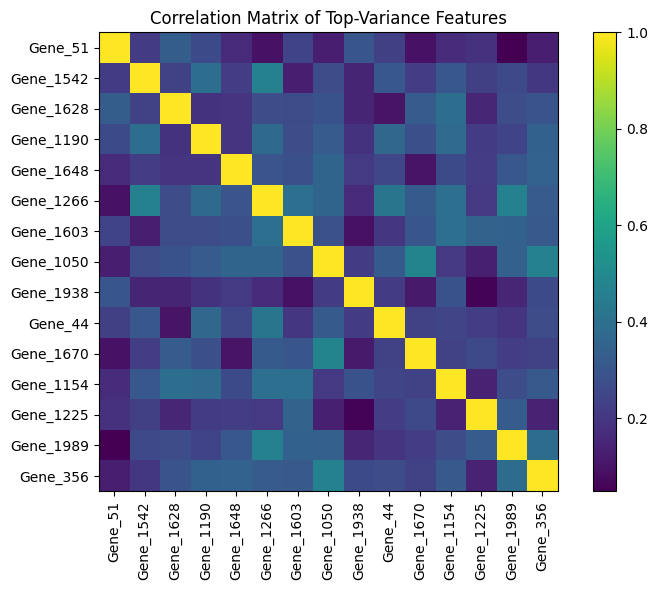

In [5]:

# Variance computation per feature and pick the top 15
feature_df = df.drop(columns=[TARGET_COL])
variances = feature_df.var().sort_values(ascending=False)
top_features = variances.head(15).index.tolist()

print("Top 15 high-variance features:")
print(top_features)

corr_matrix = feature_df[top_features].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.yticks(range(len(top_features)), top_features)
plt.title("Correlation Matrix of Top-Variance Features")
plt.tight_layout()
plt.show()


## 4. Train/Test Split
I separate features and target, then create a stratified train/test split.

In [6]:

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (49, 2000)
Test shape: (13, 2000)


## 5. PCA: Dimensionality Reduction & Visualization
I apply PCA on standardized features to:
- Inspect how many components explain most variance.
- Visualize samples in the first two principal components, colored by class.


Explained variance ratio (first 10 components):
[0.19760439 0.0177366  0.0170229  0.01684574 0.01649973 0.01643836
 0.01617152 0.01593114 0.01572117 0.01533442]


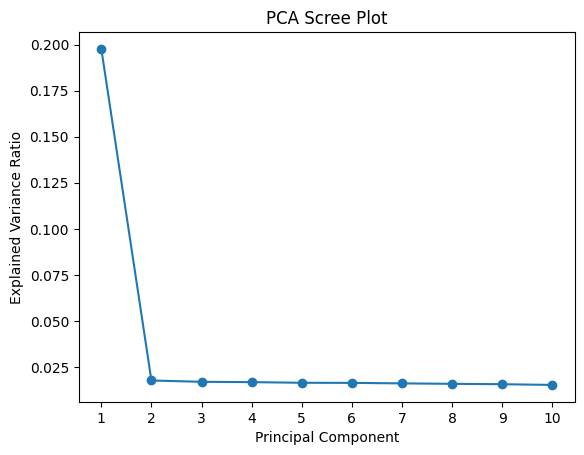

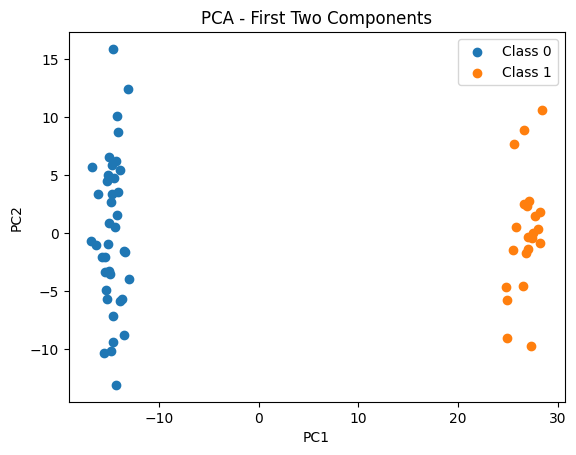

In [7]:
# From the sklearn.preprocessing library, fetaures are standardized
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Fit PCA
n_components = 10
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratio (first 10 components):")
print(explained_var)

#Scree plot
plt.figure()
plt.plot(range(1, n_components + 1), explained_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.xticks(range(1, n_components + 1))
plt.show()

#2D PCA scatter colored by class
plt.figure()
for label in np.unique(y):
    mask = (y.values == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Class {label}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - First Two Components")
plt.legend()
plt.show()


## 6. Baseline Model: Logistic Regression
Now, I start with a simple, linear baseline model using all features with standardization.

This is often not sufficient for high-dimensional gene-expression data, but it gives a reference point.

Logistic Regression CV Accuracy: 1.000 ± 0.000

Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1: 1.0

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



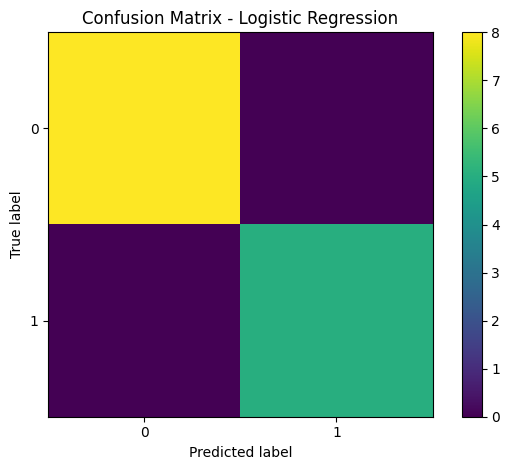

In [8]:
log_reg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(log_reg_pipeline, X_train, y_train, cv=cv, scoring="accuracy")

print("Logistic Regression CV Accuracy: {:.3f} ± {:.3f}".format(cv_scores.mean(), cv_scores.std()))

# Fit on full training data and evaluate on test set
log_reg_pipeline.fit(X_train, y_train)
y_pred_lr = log_reg_pipeline.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Test Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Test Recall:", recall_score(y_test, y_pred_lr, zero_division=0))
print("Test F1:", f1_score(y_test, y_pred_lr, zero_division=0))

print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr, zero_division=0))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plt.imshow(cm_lr, interpolation="nearest")
plt.title("Confusion Matrix - Logistic Regression")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


Notes:
Whilst working through this project I have learnt that even if the baseline performs well, high-dimensional gene data often benefits from:
- Feature selection (keep only informative genes)
- Nonlinear models like SVM with RBF kernel or neural networks.

Next, I try a more advanced pipeline using feature selection & SVM, then a neural network.

## 7.SVM with RBF Kernel Model and Feature Selection
I use `SelectKBest` to keep the top K genes and then train an SVM with an RBF kernel.
This can capture nonlinear decision boundaries in high-dimensional data.

SVM (RBF) + SelectKBest CV Accuracy: 1.000 ± 0.000

Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1: 1.0

Classification Report (SVM RBF):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



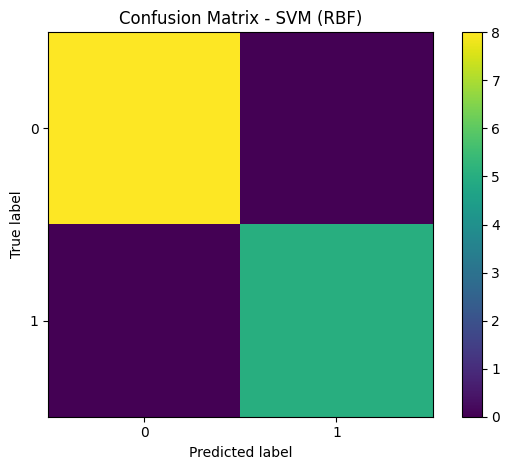

In [9]:
K_FEATURES = 50

svm_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=K_FEATURES)),
    ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

cv_scores_svm = cross_val_score(svm_pipeline, X_train, y_train, cv=cv, scoring="accuracy")
print("SVM (RBF) + SelectKBest CV Accuracy: {:.3f} ± {:.3f}".format(cv_scores_svm.mean(), cv_scores_svm.std()))

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Test Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Test Recall:", recall_score(y_test, y_pred_svm, zero_division=0))
print("Test F1:", f1_score(y_test, y_pred_svm, zero_division=0))

print("\nClassification Report (SVM RBF):\n")
print(classification_report(y_test, y_pred_svm, zero_division=0))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure()
plt.imshow(cm_svm, interpolation="nearest")
plt.title("Confusion Matrix - SVM (RBF)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## 8. Neural Network (MLPClassifier) Model
Here a simple fully connected neural network (multi-layer perceptron) with one or two hidden layers is used.
- Input: scaled features
- Hidden layers: e.g., 64 → 32 units
- Output: binary classification

MLP + SelectKBest CV Accuracy: 1.000 ± 0.000

Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1: 1.0

Classification Report (Neural Network MLP):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



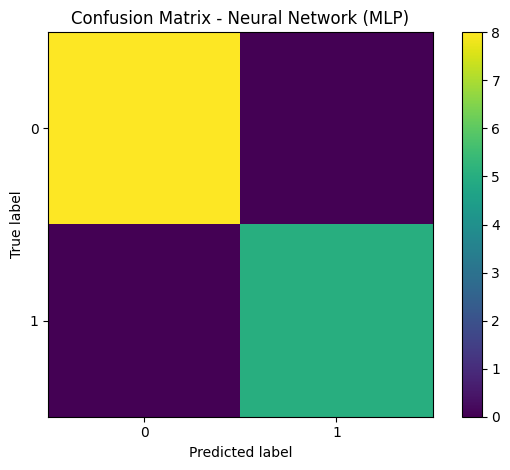

In [10]:
mlp_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=K_FEATURES)),
    ("clf", MLPClassifier(hidden_layer_sizes=(64, 32),
                          activation="relu",
                          max_iter=2000,
                          random_state=RANDOM_STATE))
])

cv_scores_mlp = cross_val_score(mlp_pipeline, X_train, y_train, cv=cv, scoring="accuracy")
print("MLP + SelectKBest CV Accuracy: {:.3f} ± {:.3f}".format(cv_scores_mlp.mean(), cv_scores_mlp.std()))

mlp_pipeline.fit(X_train, y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Test Precision:", precision_score(y_test, y_pred_mlp, zero_division=0))
print("Test Recall:", recall_score(y_test, y_pred_mlp, zero_division=0))
print("Test F1:", f1_score(y_test, y_pred_mlp, zero_division=0))

print("\nClassification Report (Neural Network MLP):\n")
print(classification_report(y_test, y_pred_mlp, zero_division=0))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure()
plt.imshow(cm_mlp, interpolation="nearest")
plt.title("Confusion Matrix - Neural Network (MLP)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## 9. ROC Curves for Model Comparison
Now, I compare the Logistic Regression, SVM (RBF), and Neural Network using ROC curves and AUC.
This is a common way to show model performance beyond simple accuracy.

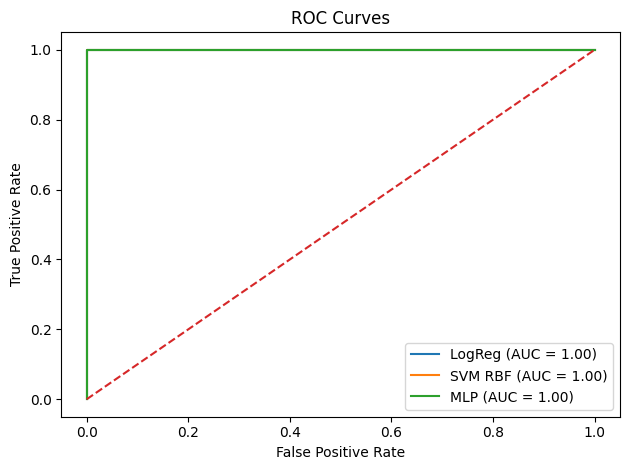

In [11]:
plt.figure()

# Logistic Regression
y_score_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {auc_lr:.2f})")

# SVM (RBF)
y_score_svm = svm_pipeline.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM RBF (AUC = {auc_svm:.2f})")

# Neural Network
y_score_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Single-Sample Prediction Example
Finally, I show how to use one of the trained pipelines (e.g., SVM with feature selection) to predict the class of a new sample.

Here I just take one row from `X_test` as an example input.

In [12]:
sample = X_test.iloc[0:1]
true_label = y_test.iloc[0]

pred_class = svm_pipeline.predict(sample)[0]
pred_proba = svm_pipeline.predict_proba(sample)[0, 1]

print("True label:", true_label)
print("Predicted label (SVM):", pred_class)
print("Predicted probability of class 1:", pred_proba)


True label: 0
Predicted label (SVM): 0
Predicted probability of class 1: 0.07655612646510151


## 11. Summary & How to Reuse This Notebook
In this notebook, I performed exploratory data analysis, including histograms and correlation checks for the highest-variance features, and then applied PCA to understand variance structure and visualize potential class separation. I began with a baseline Logistic Regression model and then improved performance by incorporating more advanced methods such as an SVM with an RBF kernel paired with feature selection, as well as a neural-network classifier (MLP) built on selected features. I evaluated model performance using cross-validation, test-set metrics, confusion matrices, and ROC curves to ensure a thorough assessment.

To reuse this notebook on a different dataset, I or anyone else only needs to update the `FILE_PATH` and `TARGET_COL`, with the option to adjust or disable feature selection for datasets with fewer features. Overall, this notebook is intentionally designed to demonstrate strong machine-learning capability while remaining clean, reusable, and not unnecessarily complex.